In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-product-images-small/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/images/31973.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/30778.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/19812.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/22735.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/38246.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/16916.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/52876.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/39500.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44758.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/59454.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44951.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/

In [3]:
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import random
import requests
from io import BytesIO

In [4]:
# Parameters
data_dir = '/kaggle/input/fashion-product-images-small/images'
img_size = 128

In [5]:
df = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv", on_bad_lines='skip')
df = df[:10000]
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [6]:
# Assuming 'data_dir' and 'img_size' are defined earlier
list_of_data = []
total_processed = 0
total_skipped = 0

# Use tqdm to wrap around df.iterrows() for progress tracking
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    img_path = os.path.join(data_dir, str(row['id']) + ".jpg")

    # Check if the image file exists before trying to read it
    if not os.path.exists(img_path):
        print(f"Warning: Image file not found at path: {img_path}")
        total_skipped += 1  # Increment skipped counter for missing file
        continue  # Skip to the next iteration if the image is not found

    # Check for missing class labels
    if any(row.get(key) is None for key in ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']):
        print(f"Skipping image due to missing class labels for ID: {row['id']}")
        total_skipped += 1  # Increment skipped counter for missing class labels
        continue  # Skip to the next iteration if any class label is missing

    img_arr = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshape images to preferred size

    json_dict = {
        'image': resized_arr.tolist(),  # Convert NumPy array to list for JSON serialization
        'class_1': row['gender'],
        'class_2': row['masterCategory'],
        'class_3': row['subCategory'],
        'class_4': row['articleType'],
        'class_5': row['baseColour'],
        'class_6': row['season'],
        'class_7': row['usage']
    }

    # Append the json_dict to the list
    list_of_data.append(json_dict)
    total_processed += 1  # Increment processed counter

# Print the summary
print(f"Total images processed: {total_processed}")
print(f"Total images skipped: {total_skipped}")

Processing Images:  67%|██████▋   | 6703/10000 [02:17<00:38, 85.86it/s]

Processing Images: 100%|██████████| 10000/10000 [03:23<00:00, 49.22it/s]

Total images processed: 9999
Total images skipped: 1


In [7]:
# Splitting into x_train and y_train
x_train = []
y_train = []

for data in list_of_data:
    x_train.append(data['image'])
    y_train.append([data['class_1'], data['class_2'], data['class_3'], data['class_4'], data['class_5'], data['class_6'], data['class_7']])

x_train = np.array(x_train) / 255
x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 3)

In [8]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

In [9]:
y_train = np.array(y_train)

# Initialize lists to store mappings and class arrays
class_maps = {}
class_arrays = []
num_classes = 7  # Update this if you have more or fewer classes

# Loop through each class
for i in range(num_classes):
    class_data = y_train[:, i]  # Get data for the current class
    class_map = {j: idx for idx, j in enumerate(set(class_data))}
    class_arr = np.array([class_map[x] for x in class_data])
    
    class_maps[f'map_{i + 1}'] = class_map  # Store the mapping
    class_arrays.append(class_arr)  # Append the class array to the list

# Convert class_arrays list to a 2D NumPy array if needed
class_arrays = np.array(class_arrays).T  # Transpose to get the correct shape
# Assuming you have already determined the number of classes for each task
c_1 = len(class_maps['map_1'])  # Number of classes for gender
c_2 = len(class_maps['map_2'])  # Number of classes for master category
c_3 = len(class_maps['map_3'])  # Number of classes for sub-category
c_4 = len(class_maps['map_4'])  # Number of classes for article type
c_5 = len(class_maps['map_5'])  # Number of classes for base color
c_6 = len(class_maps['map_6'])  # Number of classes for season
c_7 = len(class_maps['map_7'])  # Number of classes for usage
class_arr_gender = class_arrays[:, 0]  # Adjust the index based on your arrangement
class_arr_master_category = class_arrays[:, 1]
class_arr_sub_category = class_arrays[:, 2]
class_arr_article_type = class_arrays[:, 3]
class_arr_base_colour = class_arrays[:, 4]
class_arr_season = class_arrays[:, 5]
class_arr_usage = class_arrays[:, 6]

## Gender

In [10]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for gender classification
gender_branch = tf.keras.layers.Dense(c_1, activation='softmax', name='gender_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[gender_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_output (Dense)           │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,101 (33.49 MB)

 Trainable params: 8,780,101 (33.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [12]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'gender_output': class_arr_gender,  # Assuming you have a corresponding class array
#         'masterCategory_output': class_arr_master_category,
#         'subCategory_output': class_arr_sub_category,
#         'articleType_output': class_arr_article_type,
#         'baseColour_output': class_arr_base_colour,
#         'season_output': class_arr_season,
#         'usage_output': class_arr_usage
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10


I0000 00:00:1729952409.171799     141 service.cc:145] XLA service 0x78806400aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729952409.171900     141 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729952409.171908     141 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/125 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2843 - loss: 4.2814

I0000 00:00:1729952414.838938     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.4609 - loss: 1.5390 - val_accuracy: 0.7280 - val_loss: 0.7894
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7349 - loss: 0.6855 - val_accuracy: 0.8270 - val_loss: 0.5132
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8118 - loss: 0.5030 - val_accuracy: 0.8375 - val_loss: 0.4476
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8526 - loss: 0.4139 - val_accuracy: 0.8615 - val_loss: 0.4279
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8777 - loss: 0.3318 - val_accuracy: 0.8460 - val_loss: 0.4494
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8998 - loss: 0.2802 - val_accuracy: 0.8715 - val_loss: 0.4396
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9201 - loss: 0.2312 - val_accuracy: 0.8600 - val_loss: 0.4532
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9339 - loss: 0.1832 - val_accuracy: 0.86

In [13]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history.csv', index=False)

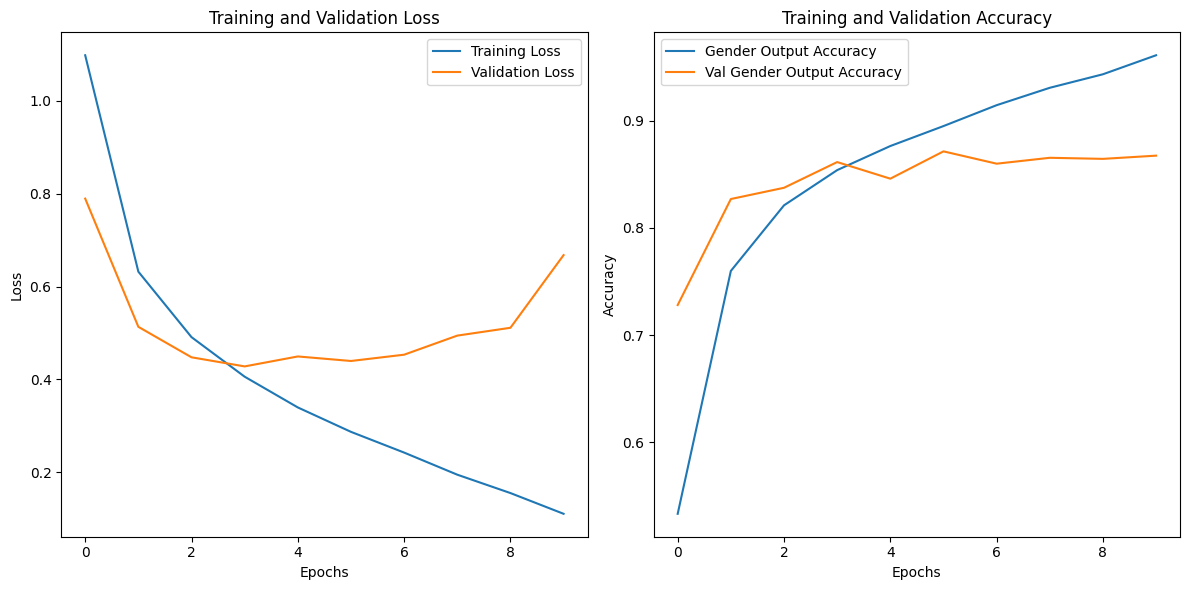

In [14]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Gender Output Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Gender Output Accuracy')

# plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
# plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')

# plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
# plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')

# plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
# plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')

# plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
# plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')

# plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
# plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')

# plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')
# plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

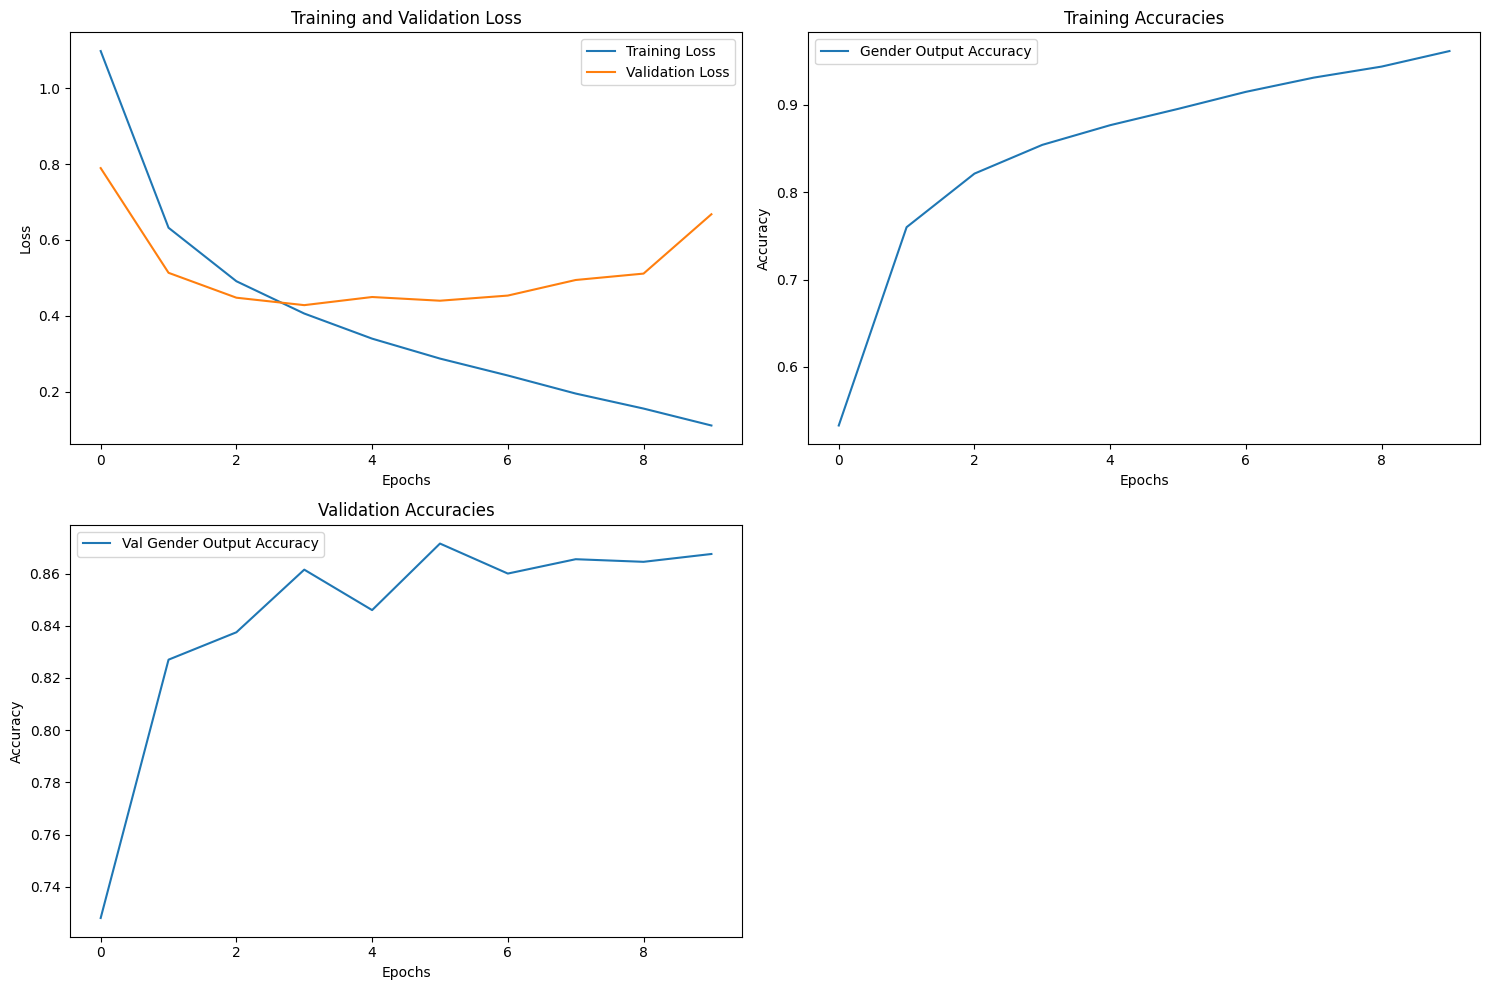

In [15]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Gender Output Accuracy')
# plt.plot(history.history['masterCategory_output_accuracy'], label='Master Category Accuracy')
# plt.plot(history.history['subCategory_output_accuracy'], label='Sub Category Accuracy')
# plt.plot(history.history['articleType_output_accuracy'], label='Article Type Accuracy')
# plt.plot(history.history['baseColour_output_accuracy'], label='Base Colour Accuracy')
# plt.plot(history.history['season_output_accuracy'], label='Season Accuracy')
# plt.plot(history.history['usage_output_accuracy'], label='Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Gender Output Accuracy')
# plt.plot(history.history['val_masterCategory_output_accuracy'], label='Val Master Category Accuracy')
# plt.plot(history.history['val_subCategory_output_accuracy'], label='Val Sub Category Accuracy')
# plt.plot(history.history['val_articleType_output_accuracy'], label='Val Article Type Accuracy')
# plt.plot(history.history['val_baseColour_output_accuracy'], label='Val Base Colour Accuracy')
# plt.plot(history.history['val_season_output_accuracy'], label='Val Season Accuracy')
# plt.plot(history.history['val_usage_output_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## masterCategory

In [16]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for master category classification
master_category_branch = tf.keras.layers.Dense(c_2, activation='softmax', name='masterCategory_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[master_category_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masterCategory_output (Dense)   │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,614 (33.50 MB)

 Trainable params: 8,780,614 (33.50 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [18]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'masterCategory_output': class_arr_master_category
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5656 - loss: 1.6178 - val_accuracy: 0.9135 - val_loss: 0.2725
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9095 - loss: 0.2671 - val_accuracy: 0.9520 - val_loss: 0.1903
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9329 - loss: 0.2365 - val_accuracy: 0.9430 - val_loss: 0.1763
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9603 - loss: 0.1268 - val_accuracy: 0.9490 - val_loss: 0.1655
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9708 - loss: 0.0952 - val_accuracy: 0.9645 - val_loss: 0.1276
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9804 - loss: 0.0628 - val_accuracy: 0.9725 - val_loss: 0.1110
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9838 - loss: 0.0501 - val_accuracy: 0.9610 - val_loss: 0.1797
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9866 - loss: 0.0445 - val_accu

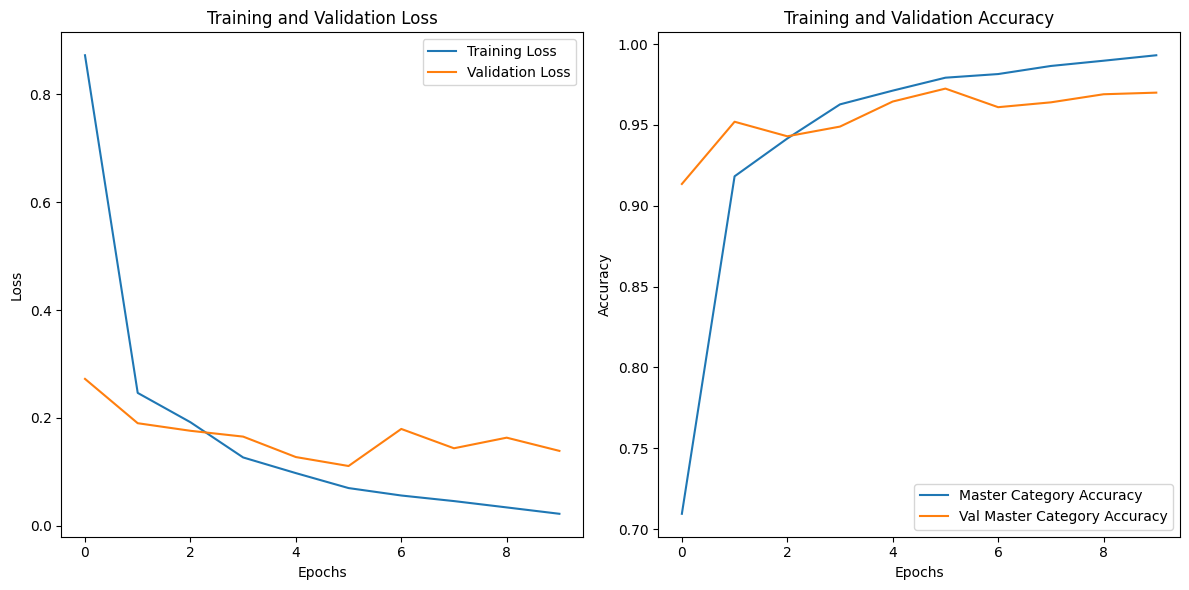

In [19]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Master Category Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

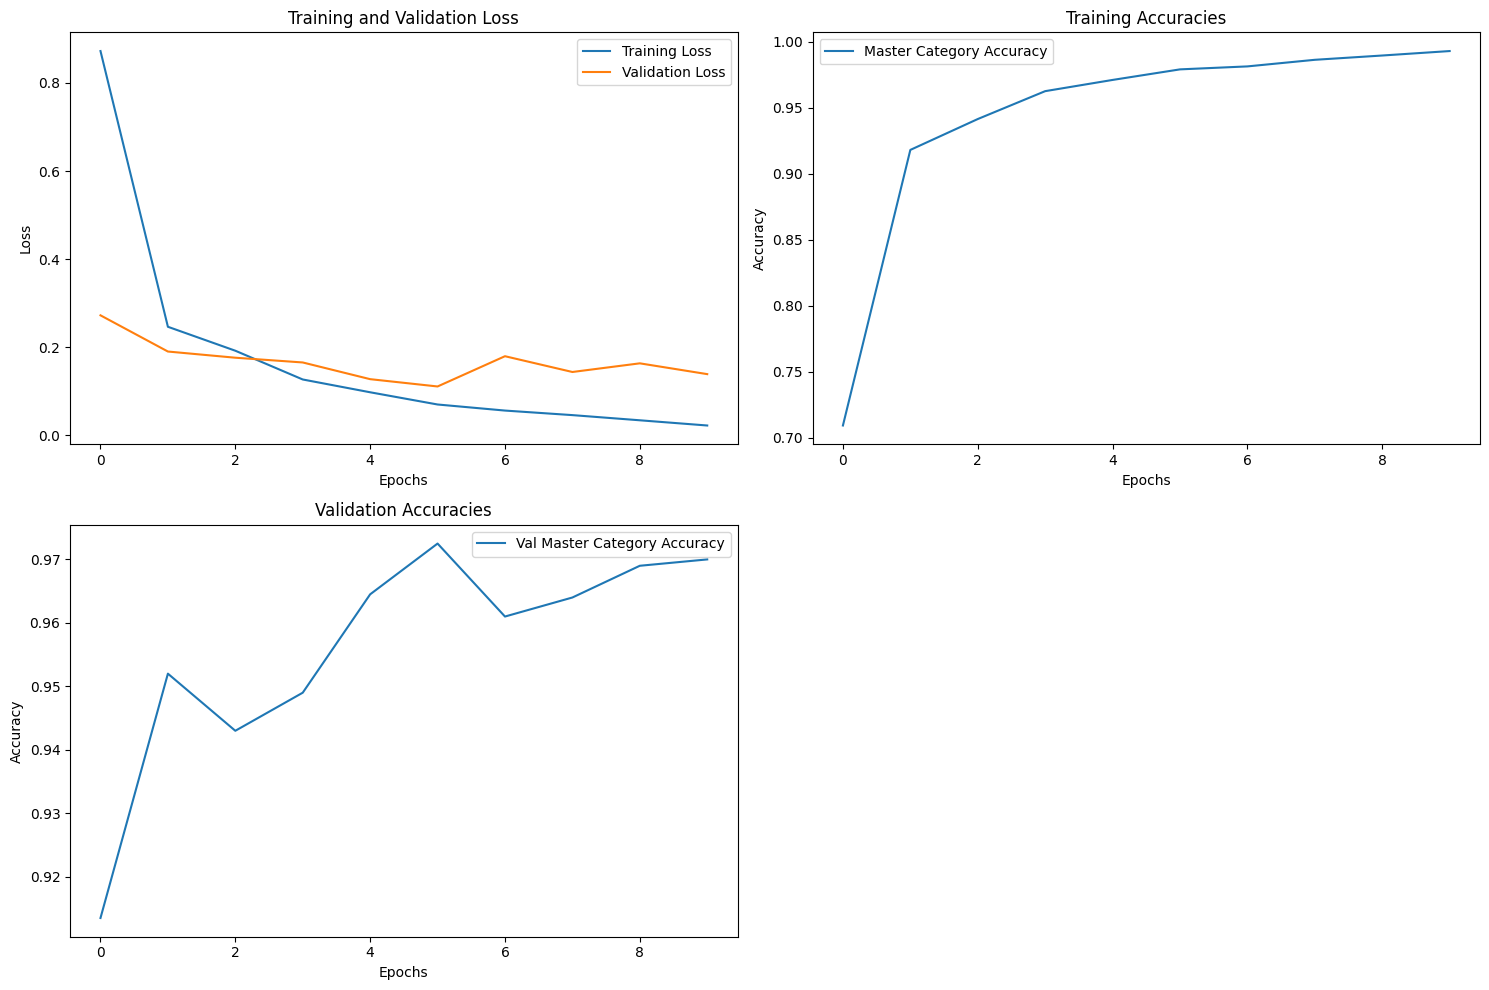

In [20]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Master Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## sub_category

In [21]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for sub-category classification
sub_category_branch = tf.keras.layers.Dense(c_3, activation='softmax', name='subCategory_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[sub_category_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subCategory_output (Dense)      │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,798,056 (33.56 MB)

 Trainable params: 8,798,056 (33.56 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [23]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'subCategory_output': class_arr_sub_category
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.3595 - loss: 3.3326 - val_accuracy: 0.7715 - val_loss: 0.9267
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7755 - loss: 0.8714 - val_accuracy: 0.8510 - val_loss: 0.5652
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8664 - loss: 0.4835 - val_accuracy: 0.8860 - val_loss: 0.4472
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9027 - loss: 0.3464 - val_accuracy: 0.8975 - val_loss: 0.4087
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9278 - loss: 0.2450 - val_accuracy: 0.9130 - val_loss: 0.3462
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9463 - loss: 0.1887 - val_accuracy: 0.9030 - val_loss: 0.4172
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9590 - loss: 0.1273 - val_accuracy: 0.9095 - val_loss: 0.4022
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9693 - loss: 0.0907 - val_accu

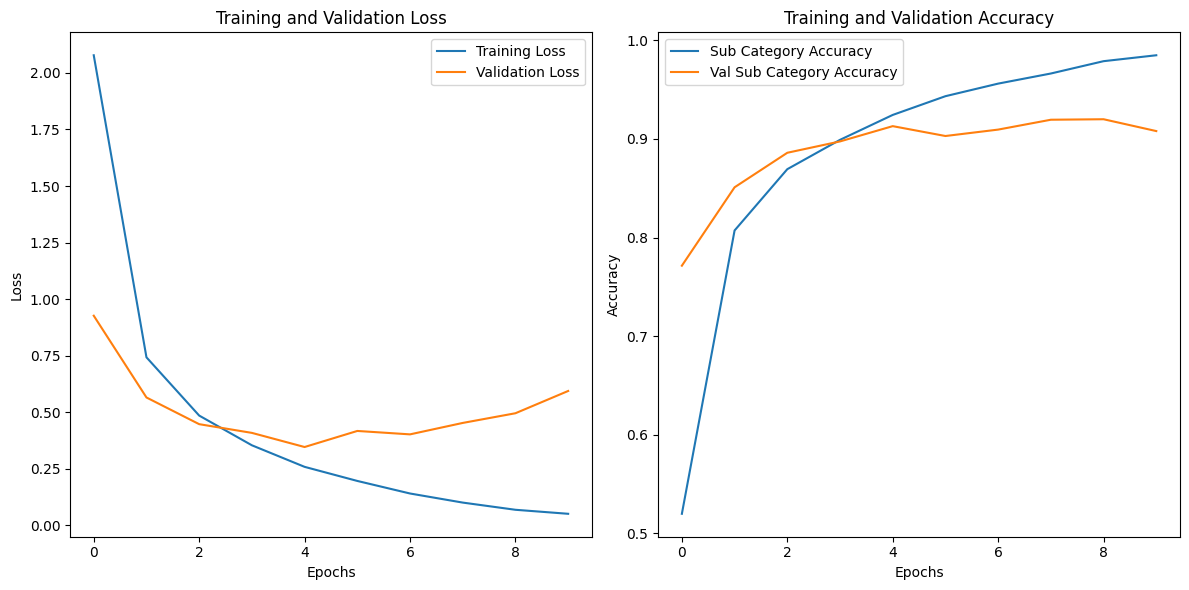

In [24]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Sub Category Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Sub Category Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

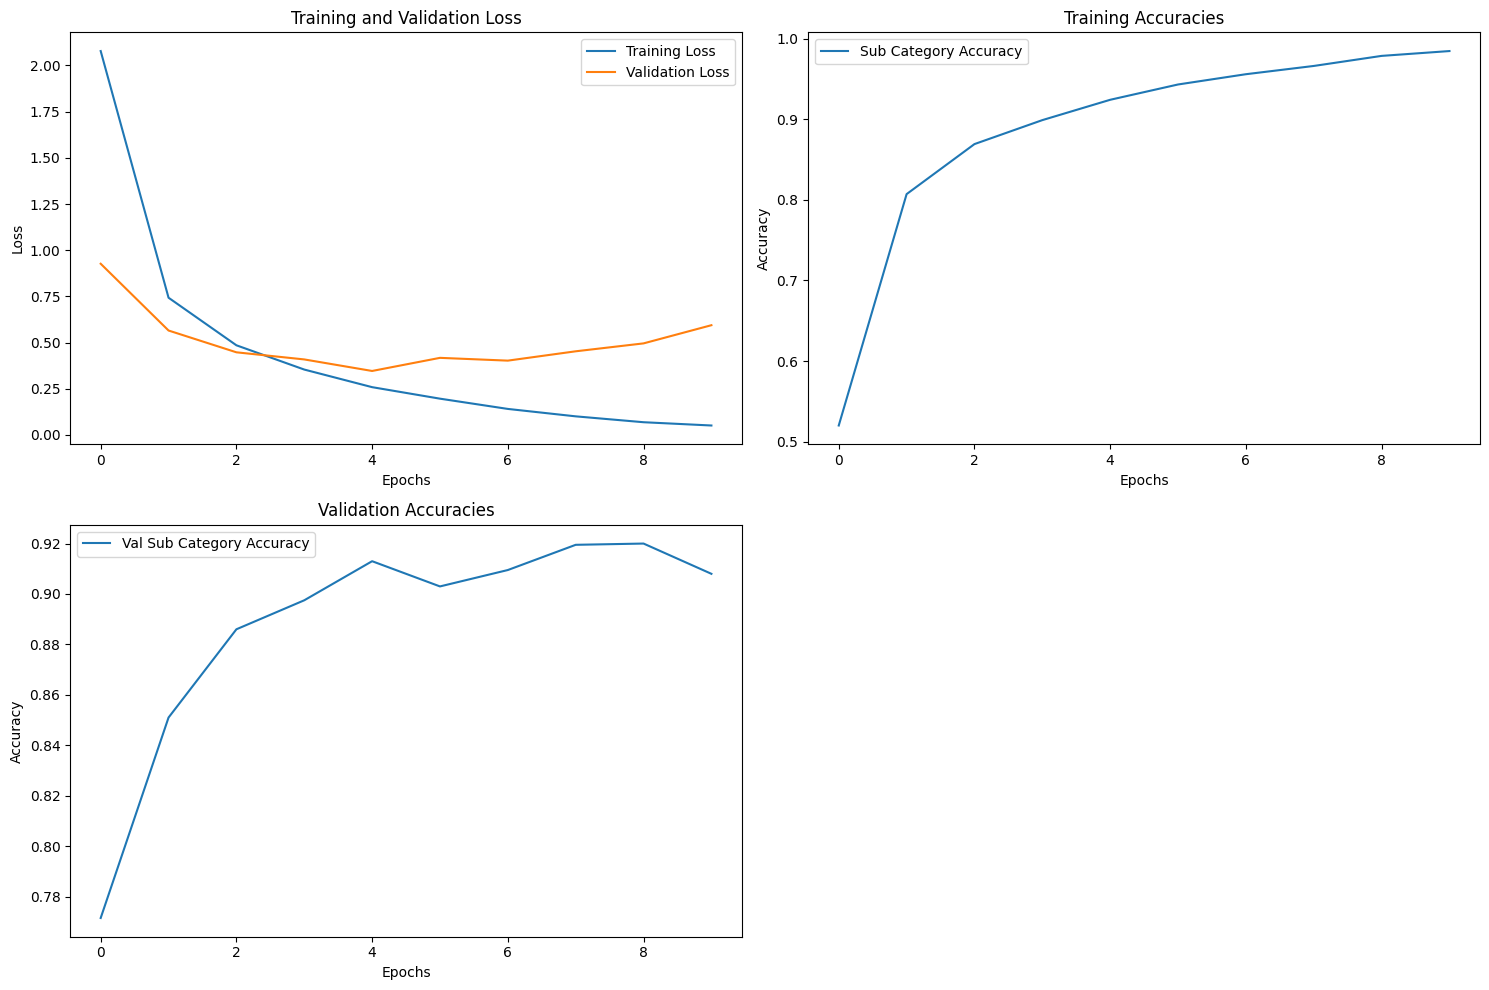

In [25]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Sub Category Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Sub Category Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## article_type

In [26]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for article type classification
article_type_branch = tf.keras.layers.Dense(c_4, activation='softmax', name='articleType_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[article_type_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ articleType_output (Dense)      │ (None, 127)            │        65,151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,842,687 (33.73 MB)

 Trainable params: 8,842,687 (33.73 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [28]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'articleType_output': class_arr_article_type

    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1503 - loss: 3.9144 - val_accuracy: 0.3865 - val_loss: 2.5526
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5698 - loss: 1.7686 - val_accuracy: 0.6130 - val_loss: 1.4804
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7036 - loss: 1.0922 - val_accuracy: 0.7270 - val_loss: 1.0637
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7657 - loss: 0.7779 - val_accuracy: 0.7040 - val_loss: 1.2429
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8181 - loss: 0.5882 - val_accuracy: 0.7600 - val_loss: 0.9158
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8815 - loss: 0.3621 - val_accuracy: 0.7635 - val_loss: 0.9776
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9187 - loss: 0.2516 - val_accuracy: 0.7620 - val_loss: 1.1906
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9450 - loss: 0.1698 - val_accu

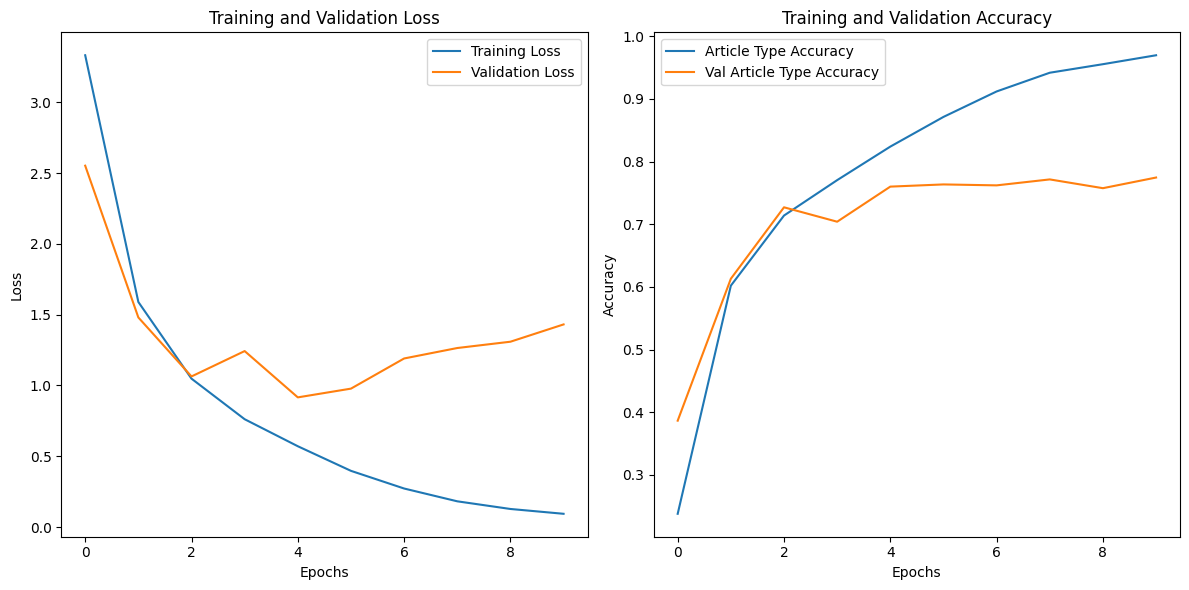

In [29]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Article Type Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Article Type Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

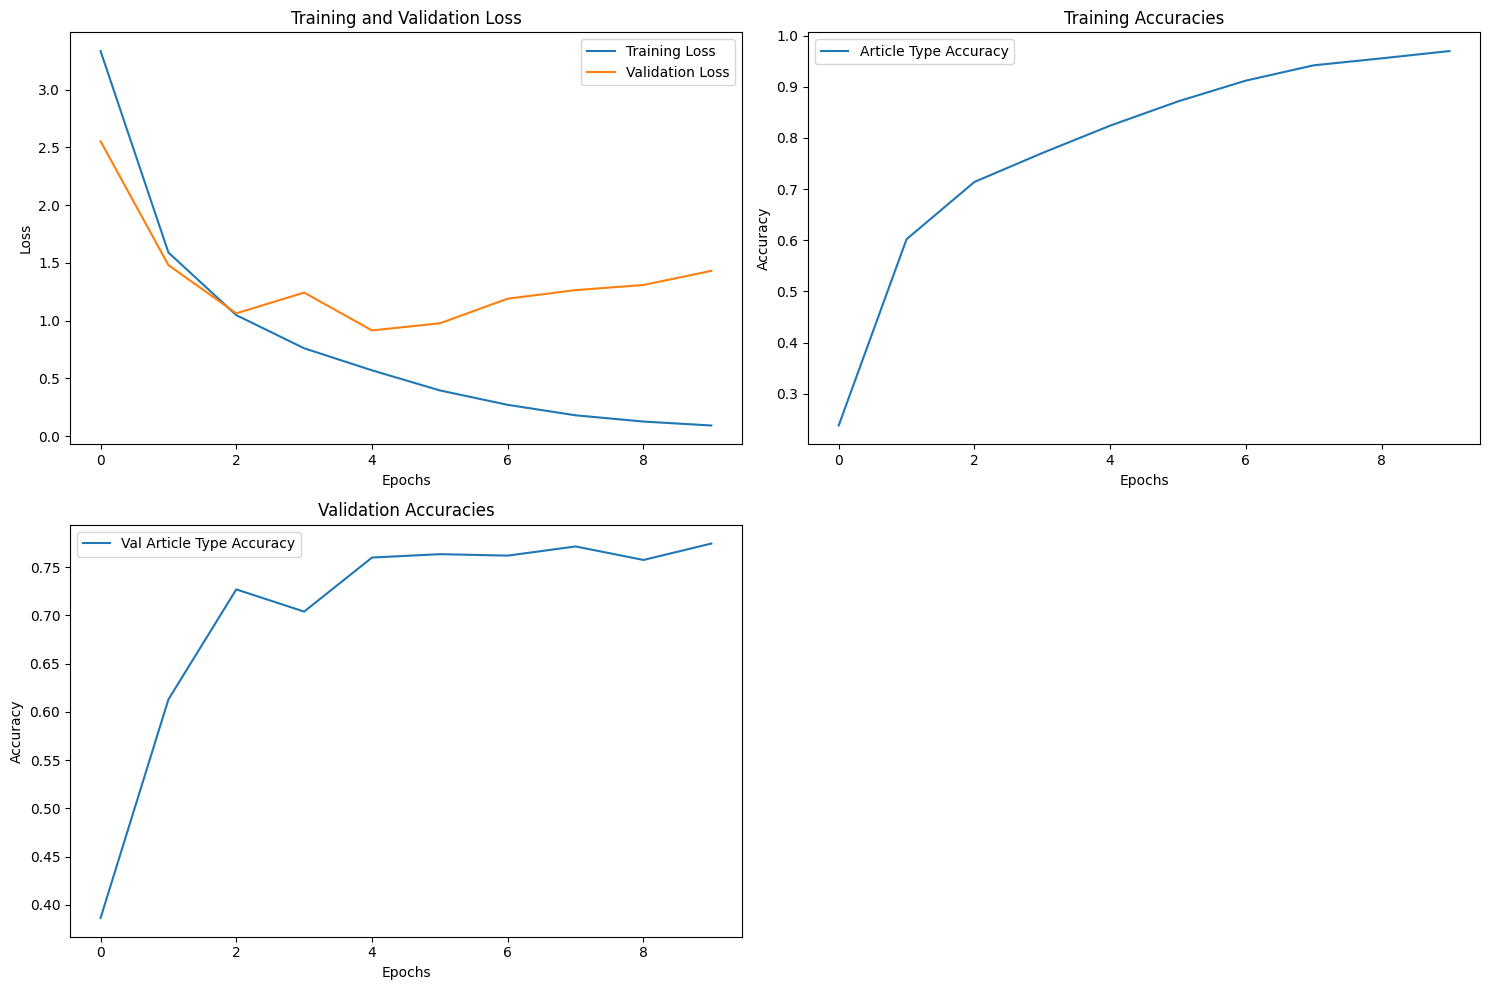

In [30]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Article Type Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Article Type Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## base_colour

In [31]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for base colour classification
base_colour_branch = tf.keras.layers.Dense(c_5, activation='softmax', name='baseColour_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[base_colour_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseColour_output (Dense)       │ (None, 46)             │        23,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,801,134 (33.57 MB)

 Trainable params: 8,801,134 (33.57 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [33]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'baseColour_output': class_arr_base_colour
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2015 - loss: 3.1040 - val_accuracy: 0.3990 - val_loss: 2.1827
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4037 - loss: 2.1482 - val_accuracy: 0.4405 - val_loss: 2.0657
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4735 - loss: 1.8846 - val_accuracy: 0.5055 - val_loss: 1.7935
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5444 - loss: 1.6347 - val_accuracy: 0.5385 - val_loss: 1.6688
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5659 - loss: 1.5149 - val_accuracy: 0.5635 - val_loss: 1.4857
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5852 - loss: 1.4166 - val_accuracy: 0.5780 - val_loss: 1.4525
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6095 - loss: 1.3133 - val_accuracy: 0.5815 - val_loss: 1.4527
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6389 - loss: 1.2153 - val_accu

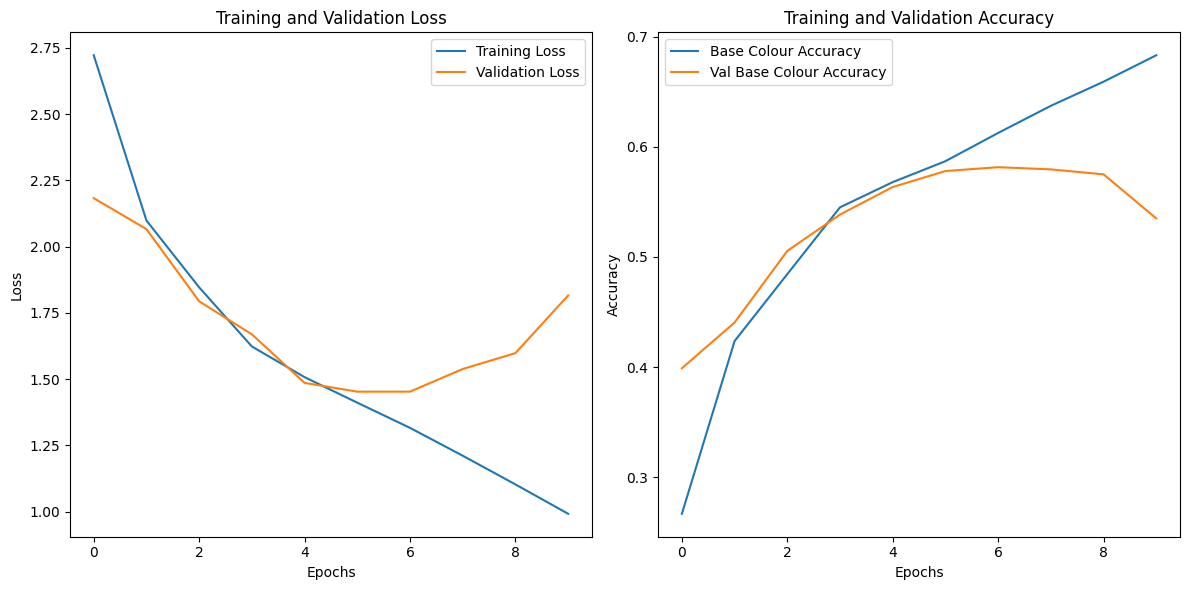

In [34]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Base Colour Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Base Colour Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

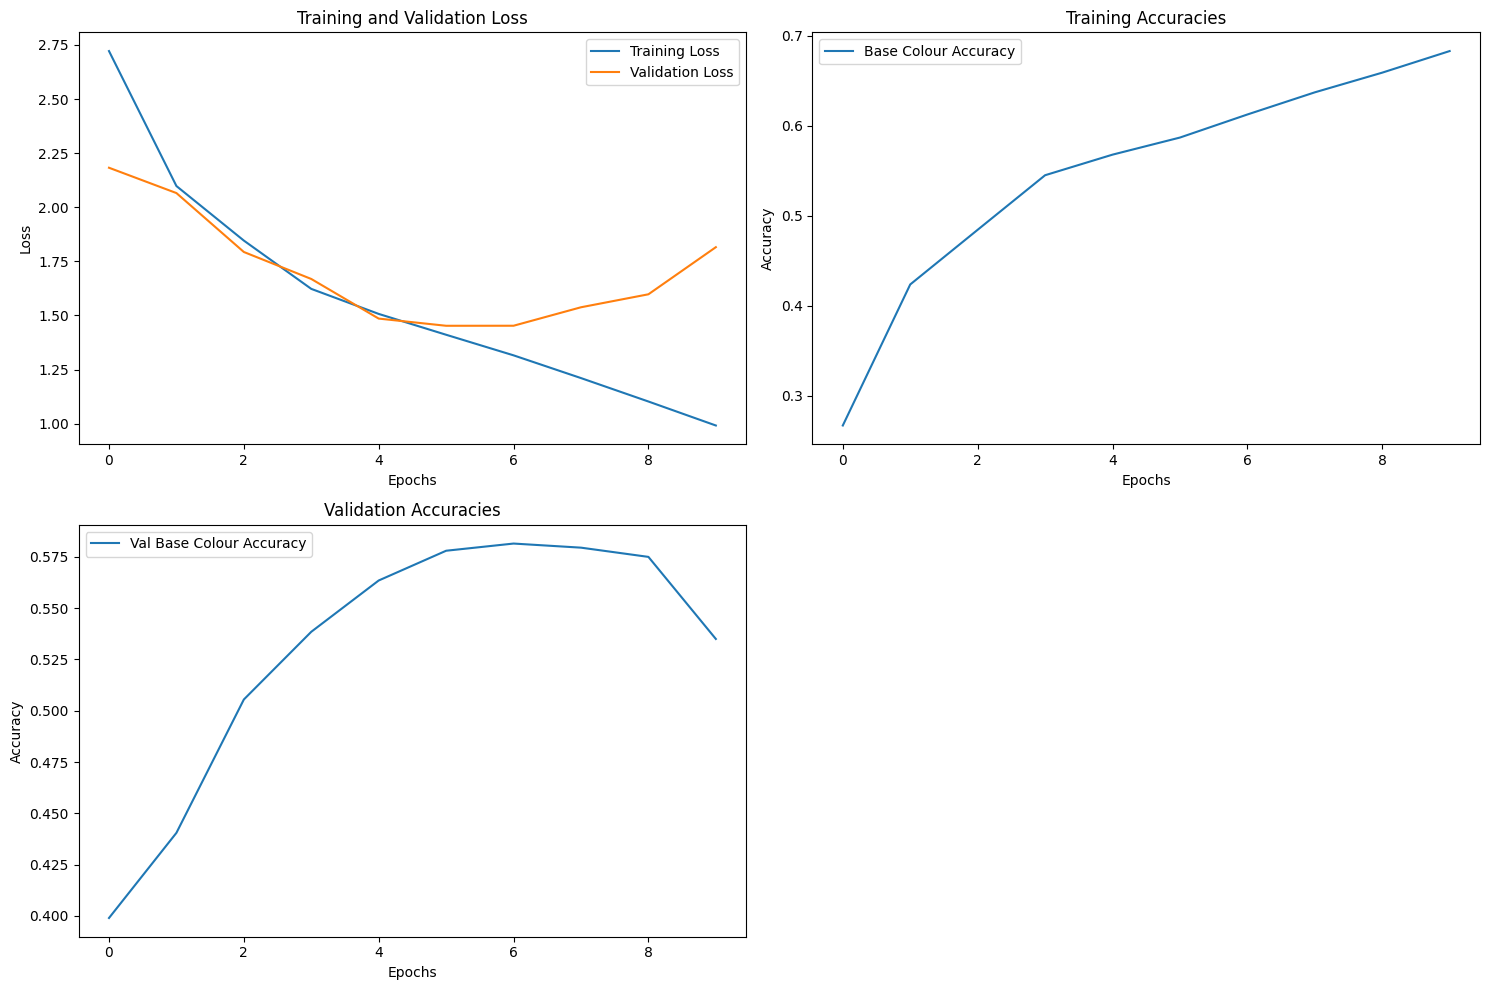

In [35]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Base Colour Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Base Colour Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## season

In [36]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for season classification
season_branch = tf.keras.layers.Dense(c_6, activation='softmax', name='season_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[season_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ season_output (Dense)           │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,780,101 (33.49 MB)

 Trainable params: 8,780,101 (33.49 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [38]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'season_output': class_arr_season
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.4169 - loss: 1.4075 - val_accuracy: 0.4905 - val_loss: 1.0552
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5630 - loss: 0.9702 - val_accuracy: 0.6025 - val_loss: 0.9214
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6204 - loss: 0.8642 - val_accuracy: 0.6280 - val_loss: 0.8874
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6647 - loss: 0.7833 - val_accuracy: 0.6460 - val_loss: 0.8405
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6812 - loss: 0.7410 - val_accuracy: 0.6580 - val_loss: 0.8172
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7193 - loss: 0.6716 - val_accuracy: 0.6780 - val_loss: 0.7947
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7486 - loss: 0.6243 - val_accuracy: 0.6775 - val_loss: 0.7800
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7794 - loss: 0.5468 - val_accu

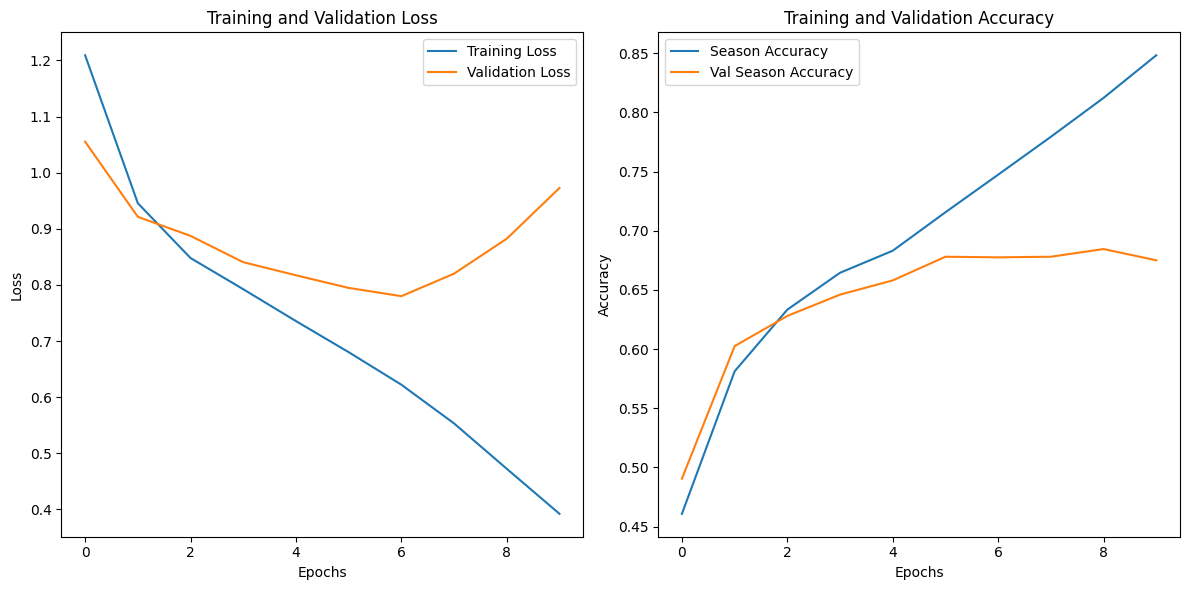

In [39]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Season Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Season Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

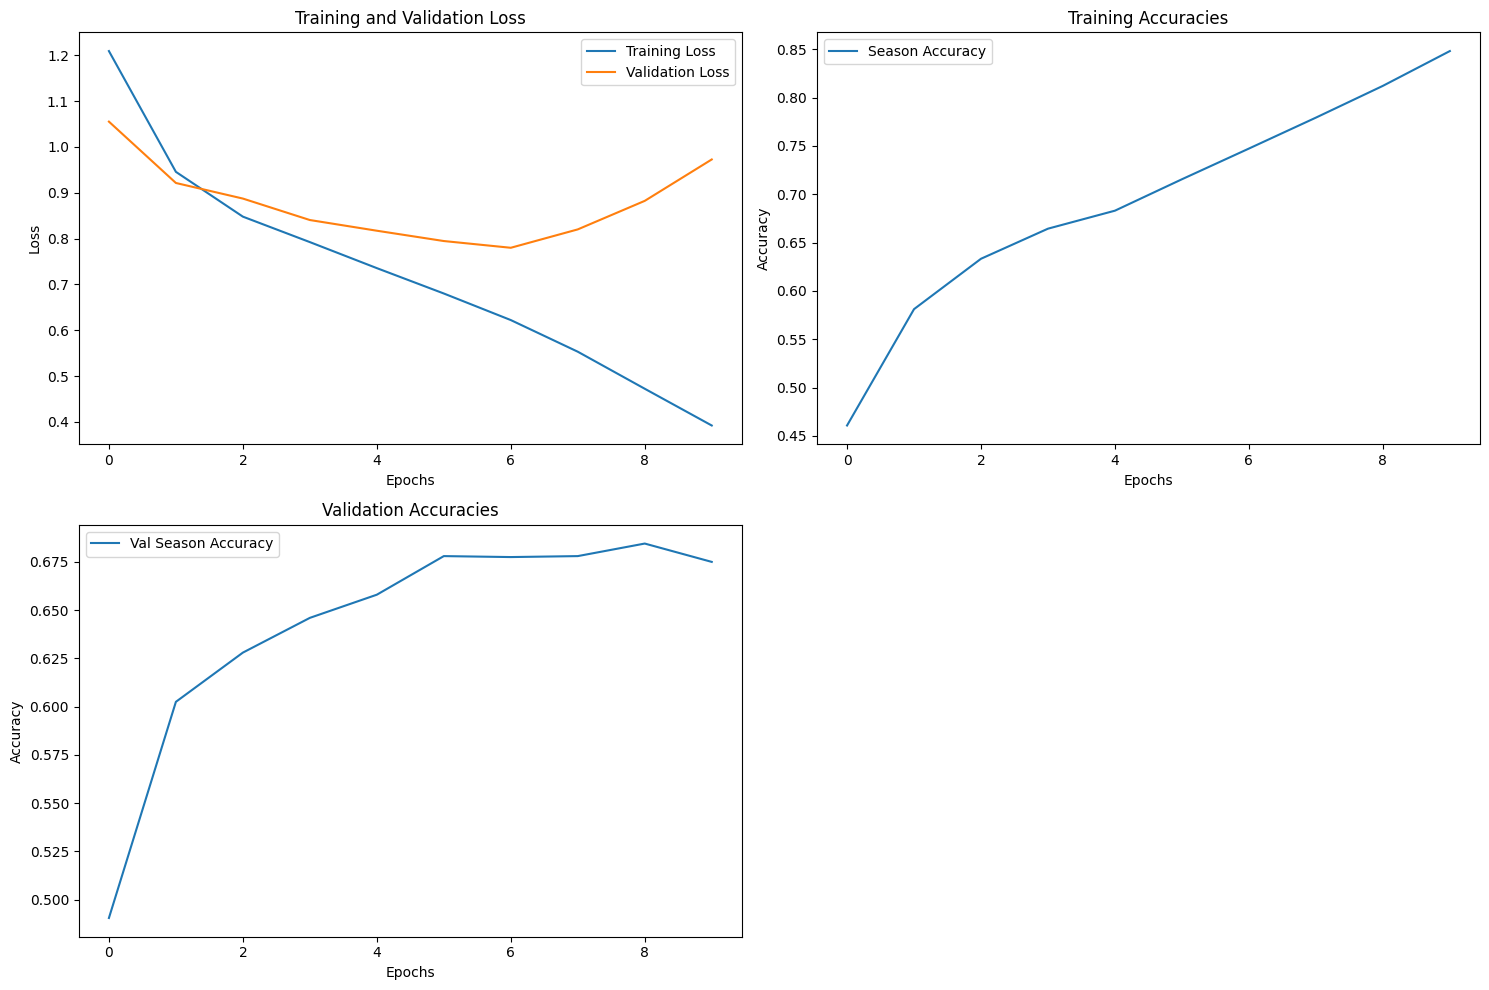

In [40]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Season Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Season Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## usage

In [41]:
# Input layer
inputs = tf.keras.layers.Input(shape=[img_size, img_size, 3], name='main_input')

# Basic CNN architecture
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Output branch for usage classification
usage_branch = tf.keras.layers.Dense(c_7, activation='softmax', name='usage_output')(x)

# Model Definition
model = tf.keras.Model(inputs=inputs, outputs=[usage_branch])

# Summary of the model to check the architecture
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ usage_output (Dense)            │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,781,640 (33.50 MB)

 Trainable params: 8,781,640 (33.50 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Model Compilation
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    loss_weights=1.0,  # Use a single float instead of a dictionary
    metrics=['accuracy']
)

In [43]:
# Model Training
history = model.fit(
    {'main_input': x_train},
    {
        'usage_output': class_arr_usage
    },
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7212 - loss: 1.3605 - val_accuracy: 0.7575 - val_loss: 0.7614
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7838 - loss: 0.6529 - val_accuracy: 0.8365 - val_loss: 0.5475
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8537 - loss: 0.4816 - val_accuracy: 0.8430 - val_loss: 0.5590
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8542 - loss: 0.4279 - val_accuracy: 0.8495 - val_loss: 0.5024
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8707 - loss: 0.3848 - val_accuracy: 0.8575 - val_loss: 0.4698
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8960 - loss: 0.3077 - val_accuracy: 0.8600 - val_loss: 0.4341
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9094 - loss: 0.2672 - val_accuracy: 0.8425 - val_loss: 0.4516
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9154 - loss: 0.2369 - val_accu

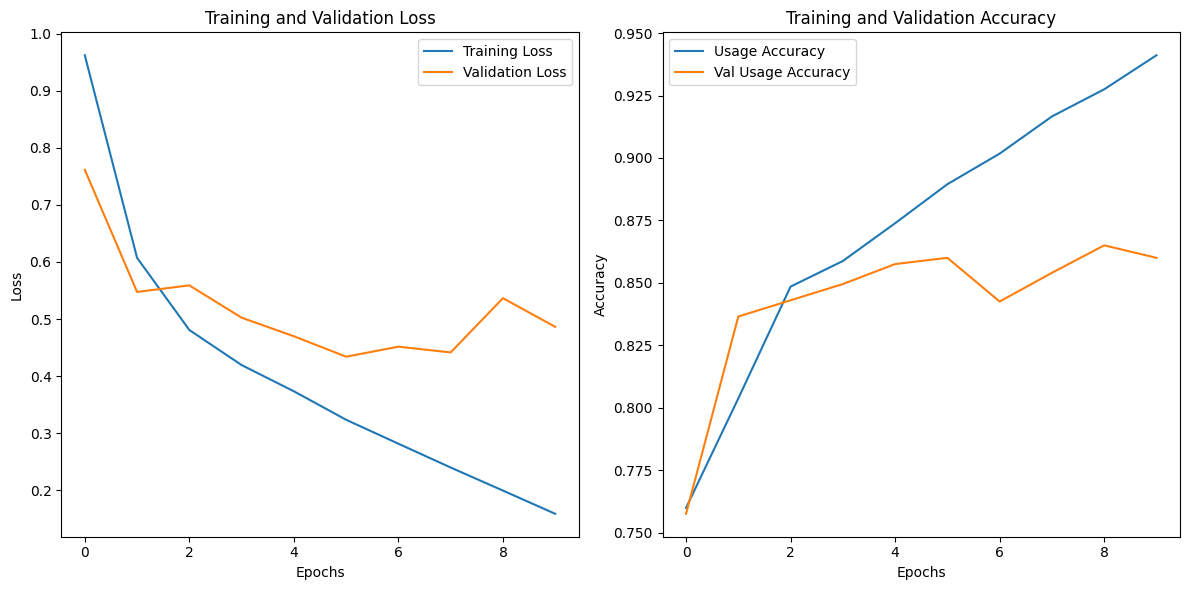

In [44]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy for all outputs
plt.subplot(1, 2, 2)


plt.plot(history.history['accuracy'], label='Usage Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

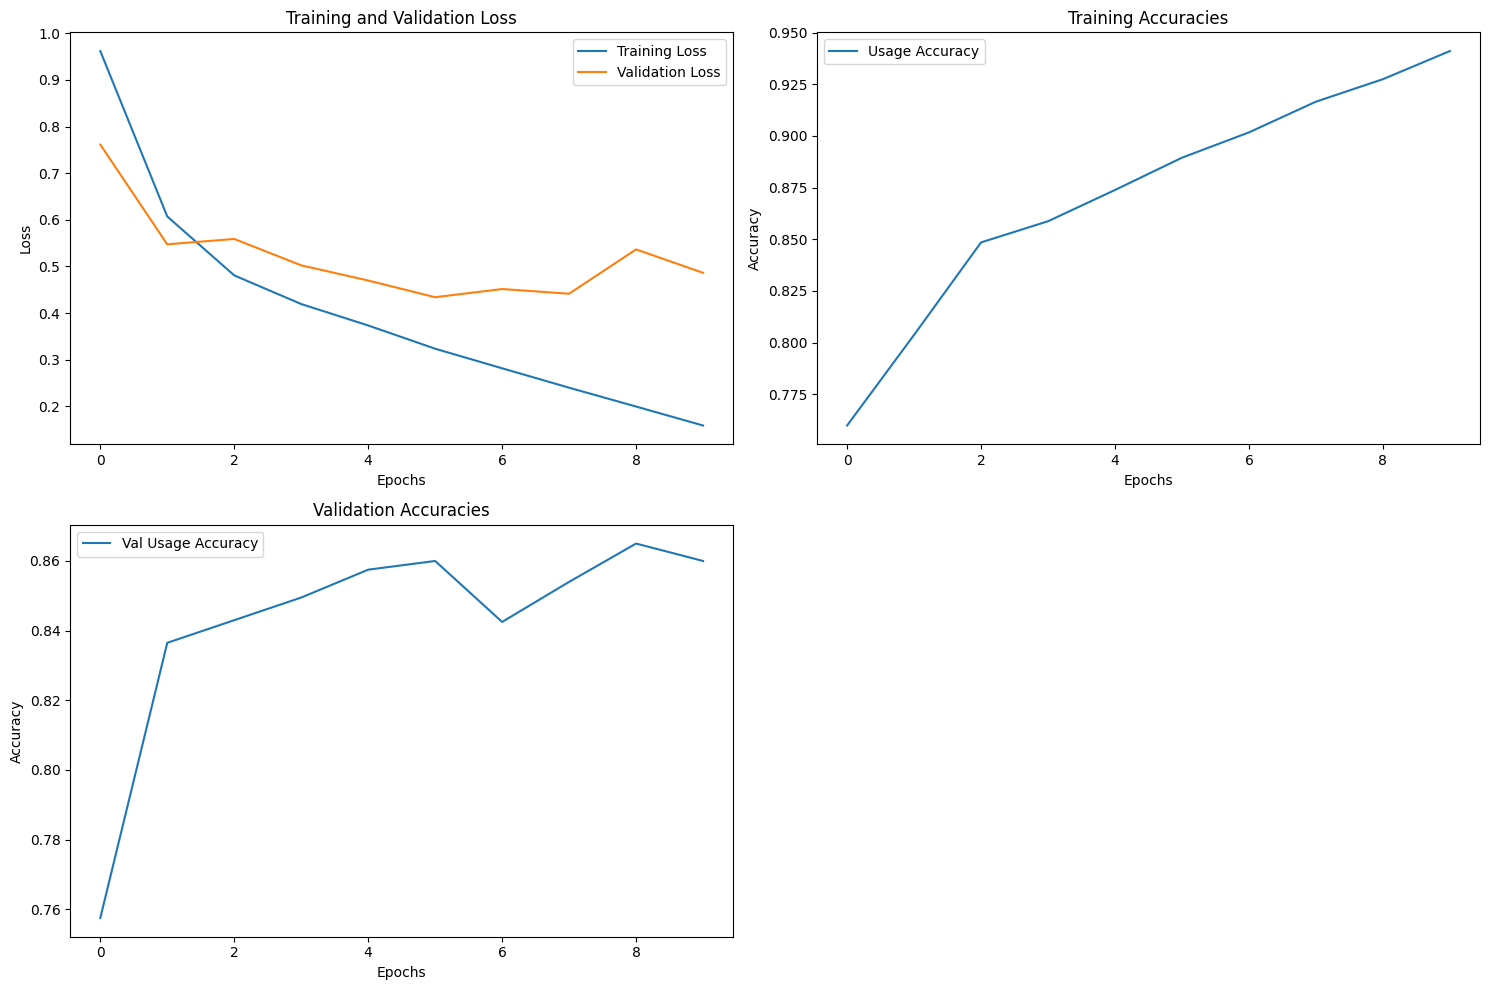

In [45]:
# Create a figure with a 2x2 grid layout for the plots
plt.figure(figsize=(15, 10))

# 1. Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. Plotting training accuracies only
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracies')
plt.legend()

# 3. Plotting validation accuracies only
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], label='Val Usage Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()